In [1]:
ON_COLAB = True

if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# torch
#!pip install torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
#!pip install torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
# other
import sys
sys.path.append('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/')
import params2
#!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path
#!pip install pandas
import pandas as pd
#!pip install imageio
import imageio
from csv import writer
from csv import reader
from PIL import Image
!pip install trimesh
import trimesh
!pip install pyrender
import pyrender
if ON_COLAB:
    from tqdm.notebook import tqdm
else:
    #!pip install tqdm
    from tqdm import tqdm
!pip install wandb
import wandb
!wandb login --relogin
# api_key = f2c3bd208d418cf11dcc2c2cbf5e4bc0fc104421

# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 660 kB 8.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 7.9 MB/s 
     |████████████████████████████████| 2.2 MB 50.1 MB/s 
     |████████████████████████████████| 1.1 MB 62.2 MB/s 
     |████████████████████████████████| 978 kB 49.5 MB/s 
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745210 sha256=30d4871081f3f56a026081753b3db7c4537d7defb472be1f9438ec3b82b93254
  Stored in directory: /root/.cache/pip/wheels/c6/83/cb/af51a0c06c33d08537b941bbfc87469e8a3c68d05f77a6a212
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.6
    Uninstalling PyOpenGL-3.1.6:
      Successfully uninstalled PyOpenGL-3.1.6
Looking in indexes: https://pypi.org/simple, https://us-python.

In [3]:
par = params2.Parameters()

print(par.resume)
print(par.batch_size)
print(par.batch_size_1)
print(par.root_path)
print(par.epochs)

True
1
60
drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/RGB_images_equatoriale
100


In [4]:
os.environ["PYOPENGL_PLATFORM"] = "egl" #opengl seems to only work with TPU
!PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"
print(os.environ['PYOPENGL_PLATFORM']) 

import OpenGL.GL as gl
print(gl.glGetString(gl.GL_VERSION))

print(gl.glGetString(gl.GL_VENDOR)) 

egl
None
None


In [ ]:
#txt_path = par.txt_path
txt_path = 'drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/poses_equatoriale_txt'

def get_nth_line(fobj, n):
    for i in range(n):
        next(fobj)
    return next(fobj)

columns = ['id', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']

with open('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/poses_equatoriale.csv', 'w') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(columns)
    for f in Path(txt_path).iterdir():
        id = int(str(f).split('/')[-1].split('.txt')[0]) 
        file = open(f)
        line4 = get_nth_line(file, 4).split('\n')[0]
        line_splitted = line4.split(' ')
        writer_object.writerow([id] + line_splitted)
    f_object.close()

In [ ]:
data = np.loadtxt('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/poses_equatoriale.csv', delimiter = ',', skiprows=1)
print('data', data[0:2,4:])
data_cos = np.cos(np.deg2rad(data[:, 4:]))
data_sin = np.sin(np.deg2rad(data[: ,4:]))
print('data_cos', data_cos.shape)
print('data_sin', data_sin)

data_cos_roll = list(data_cos[:,0])
data_sin_roll = list(data_sin[:,0])
data_cos_pitch = list(data_cos[:,1])
data_sin_pitch = list(data_sin[:,1])
data_cos_yaw = list(data_cos[:,2])
data_sin_yaw = list(data_sin[:,2])

data = np.delete(data, 0, axis=1)
data = np.delete(data, 3, axis=1)
data = np.delete(data, 3, axis=1)
data = np.delete(data, 3, axis=1)
print('data', data)
data = np.append(data, np.reshape(np.array(data_cos_roll), (-1, 1)), axis = 1)
data = np.append(data, np.reshape(np.array(data_sin_roll), (-1, 1)), axis = 1)
data = np.append(data, np.reshape(np.array(data_cos_pitch), (-1, 1)), axis = 1)
data = np.append(data, np.reshape(np.array(data_sin_pitch), (-1, 1)), axis = 1)
data = np.append(data, np.reshape(np.array(data_cos_yaw), (-1, 1)), axis = 1)
data = np.append(data, np.reshape(np.array(data_sin_yaw), (-1, 1)), axis = 1)
print('data', data)


data_sum = np.sum(data, axis=0)
print('sum',data_sum.shape)
data_mean = data_sum/data.shape[0]
print('mean', data_mean.shape)
std = np.std(data, axis = 0)
print('std', std.shape)

data [[180.         3.295156 131.317612]
 [179.999985  60.294987 171.776245]]
data_cos (9999, 3)
data_sin [[ 1.22464680e-16  5.74796232e-02  7.51061222e-01]
 [ 2.61799388e-07  8.68588162e-01  1.43039286e-01]
 [ 2.61799388e-07  2.00370505e-01  7.17961773e-01]
 ...
 [ 1.22464680e-16  2.05335883e-01  7.66359329e-01]
 [ 5.41052068e-07  8.83674536e-01 -7.76860635e-01]
 [ 1.22464680e-16  2.79991678e-01 -2.04656318e-01]]
data [[ -68.   -1. -339.]
 [ -45.   42.  -54.]
 [  -6.   35. -345.]
 ...
 [ -63.    3. -345.]
 [  -6.  -39.  -46.]
 [ -20.  -23. -123.]]
data [[-6.80000000e+01 -1.00000000e+00 -3.39000000e+02 ...  5.74796232e-02
  -6.60232566e-01  7.51061222e-01]
 [-4.50000000e+01  4.20000000e+01 -5.40000000e+01 ...  8.68588162e-01
  -9.89717011e-01  1.43039286e-01]
 [-6.00000000e+00  3.50000000e+01 -3.45000000e+02 ...  2.00370505e-01
   6.96082533e-01  7.17961773e-01]
 ...
 [-6.30000000e+01  3.00000000e+00 -3.45000000e+02 ...  2.05335883e-01
  -6.42412156e-01  7.66359329e-01]
 [-6.00000000e+

In [ ]:
class PoseDataset(Dataset):

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.poses = pd.read_csv(csv_file)
        '''self.poses = poses#.sort_values(by=["id"])
        print(self.poses)
        keep_col = ['id','x','y','z']
        self.poses = self.poses[keep_col]
        print('poses', self.poses)
        self.poses['cos_roll'] = data_cos_roll
        self.poses['sin_roll'] = data_sin_roll
        self.poses['cos_pitch'] = data_cos_pitch
        self.poses['sin_pitch'] = data_sin_pitch
        self.poses['cos_yaw'] = data_cos_yaw
        self.poses['sin_yaw'] = data_sin_yaw
        print('poses', self.poses)
        for i in range(1,4):
            #print(mean[i-1])
            #print(self.poses.iloc[:, i])
            self.poses.iloc[:, i] = self.poses.iloc[:,i].subtract(data_mean[i-1])
            #print(self.poses)
            self.poses.iloc[:, i] = self.poses.iloc[:,i].divide(std[i-1])
        print('poses', self.poses)'''
        self.root_dir = root_dir
  

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                str(self.poses.iloc[idx, 0]) + '-N_.png')
        
        img = imageio.imread(img_path, ignoregamma = True)
        rgb_img = img[:,:,:3]
        img_tensor = torch.tensor(rgb_img)/255.0
        img_tensor = np.transpose(img_tensor, (2, 0, 1))
        
        img_downsampled = F.interpolate(img_tensor, scale_factor = 0.25)
        img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
        img_downsampled = F.interpolate(img_downsampled, scale_factor = 0.25)
        img_downsampled = np.transpose(img_downsampled, (0, 2, 1))

        pose = self.poses.iloc[idx, 1:]
        pose = np.array([pose])
        pose =  pose.reshape(6)
        return img_downsampled, pose

In [ ]:
pose_dataset = PoseDataset(csv_file = 'drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/poses_equatoriale.csv',
                           root_dir='drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/RGB_images_equatoriale')
#print(len(pose_dataset))

In [7]:
# Create train val test split
n = len(pose_dataset)
n_1 = int(n/10)

train_set, val_set, test_set = torch.utils.data.random_split(
    pose_dataset, [n-(2*n_1), n_1, n_1])

print(len(train_set), len(val_set), len(test_set))

loader_train = DataLoader(train_set, batch_size=par.batch_size, shuffle=False, num_workers=2)
#print('loader', type(loader_train))
loader_val = DataLoader(val_set, batch_size=par.batch_size, shuffle=par.shuffle, num_workers=2)
loader_test = DataLoader(test_set, batch_size=par.batch_size, shuffle=par.shuffle, num_workers=2)

15993 1999 1999


In [ ]:
def print_pose(model_path, pose, t):
    #print('pose',pose)
    tm = trimesh.load(model_path) 
    mesh = pyrender.Mesh.from_trimesh(tm)
    #print('xyz_rpy', pose.shape)
    #pose = torch.squeeze(pose, dim=0) 
    #print('xyz_rpy', pose.shape)
    tx, ty, tz, rx, ry, rz = pose#.cpu().numpy()
    #print('xyz_rpy', pose)

    ty = -ty
    ry = -ry 
    rz = -rz 

    r = R.from_euler('xyz',[rx, ry, rz], degrees=True)

    Twc = np.eye(4)
    Twc[:3,:3] = r.as_matrix()
    Twc[:3,3] = np.array([tx, ty, tz])


    #print('Twc', Twc)

    im_width, im_height = (256,256)
    camK = np.array([[886.81/4,0.0,128.0],[0.0,886.81/4,128.0],[0.0,0.0,1.0]])

    camera = pyrender.IntrinsicsCamera(camK[0,0],camK[1,1],
                                        camK[0,2],camK[1,2], zfar = 700.0)

    scene=pyrender.Scene()
    scene.add(camera,pose=Twc)
    scene.add(mesh,pose=np.eye(4))
    r = pyrender.OffscreenRenderer(im_width, im_height)
    color,depth = r.render(scene)

    '''# Flip y in image space
    color = color[::-1,:,:]
    depth = depth[::-1,:]

    # Flip x in image space
    color = color[:,::-1,:]
    depth = depth[:,::-1]'''

    # Flip y in image space
    color = color[:,:,:]
    depth = depth[:,:]

    #print('image1')
    figure = plt.figure(figsize = (2, 2))
    plt.imshow(depth)
    plt.axis('off')
    plt.show()
    figure.savefig('depth_'+str(t)+'.png', bbox_inches='tight', pad_inches = 0)

    #print('depth_type', type(depth))
    #depth_downsampled = cv2.resize(depth, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    
    return depth, Twc

In [ ]:
def depth_to_point_cloud(depth, cx, cy, f):
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    valid = (depth > 0) & (depth < 1000)
    z = np.where(valid, depth, np.nan)
    x = np.where(valid, z * (c - cx) / f, 0)
    y = np.where(valid, z * (r - cy) / f, 0)
    return np.dstack((x, -y, -z))

def transform_points(pts_a, Tba):
    orig_shape = pts_a.shape
    pts_a = np.reshape(pts_a, [-1,3])
    #print('pts_a', pts_a.shape)
    pts_a = np.concatenate([pts_a, np.ones_like(pts_a[:,:1])],1)
    #print('pts_a', pts_a.shape)
    pts_b = Tba @ pts_a.T
    #print('pts_a', pts_a.shape)
    
    return np.reshape(pts_b[:3,:].T,orig_shape)

In [ ]:
import matplotlib
import matplotlib.font_manager as font_manager
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


True
cuda:0


  0%|          | 0/9999 [00:00<?, ?it/s]

0


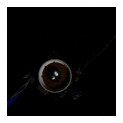

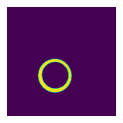

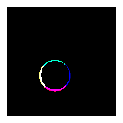

1


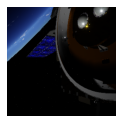

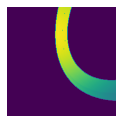

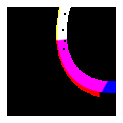

2


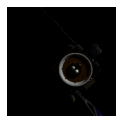

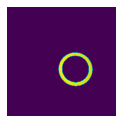

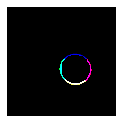

3


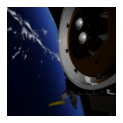

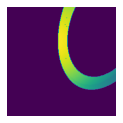

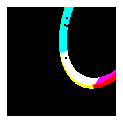

4


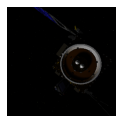

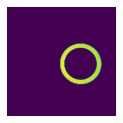

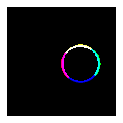

5


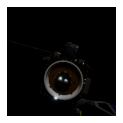

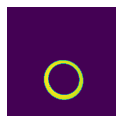

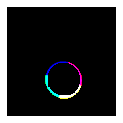

6


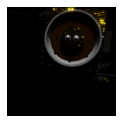

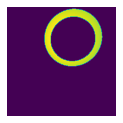

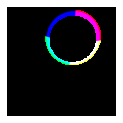

7


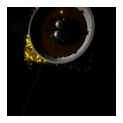

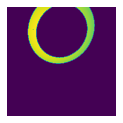

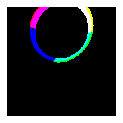

8


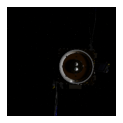

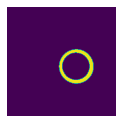

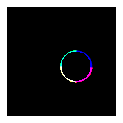

9


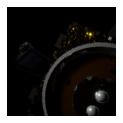

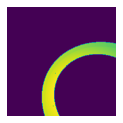

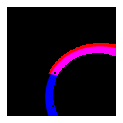

10


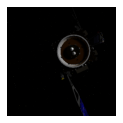

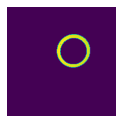

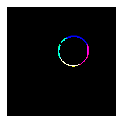

11


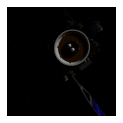

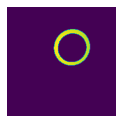

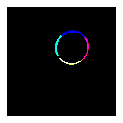

12


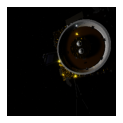

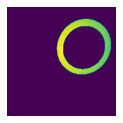

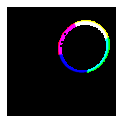

13


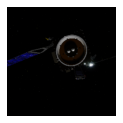

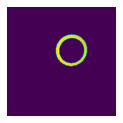

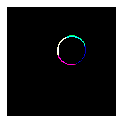

14


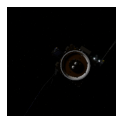

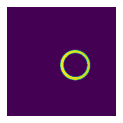

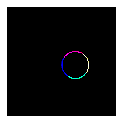

15


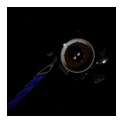

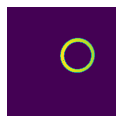

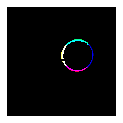

16


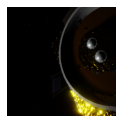

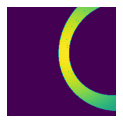

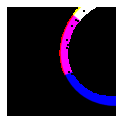

17


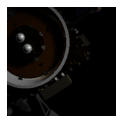

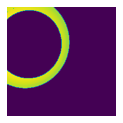

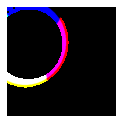

18


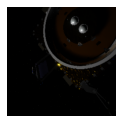

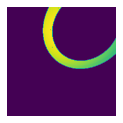

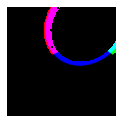

19


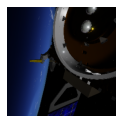

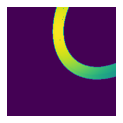

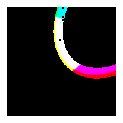

20


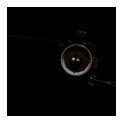

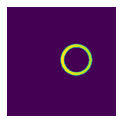

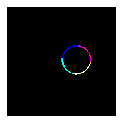

21


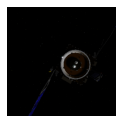

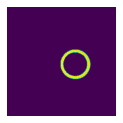

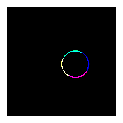

22


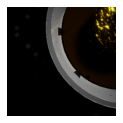

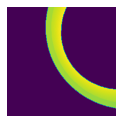

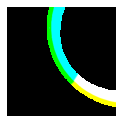

23


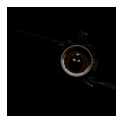

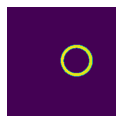

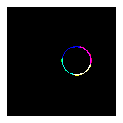

24


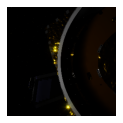

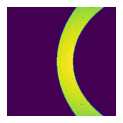

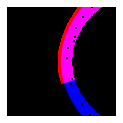

25


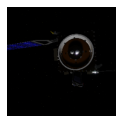

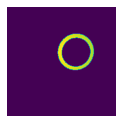

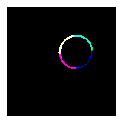

26


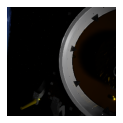

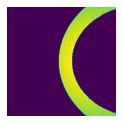

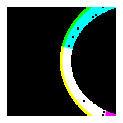

27


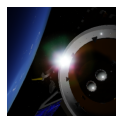

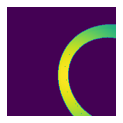

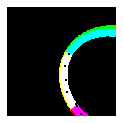

28


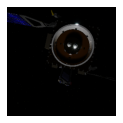

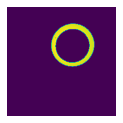

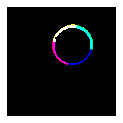

29


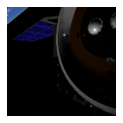

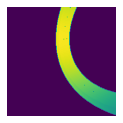

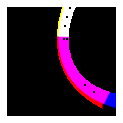

30


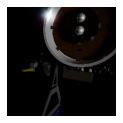

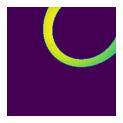

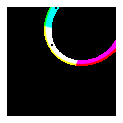

31


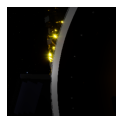

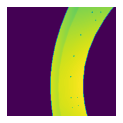

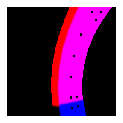

32


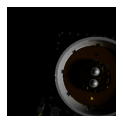

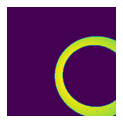

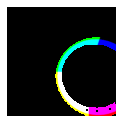

33


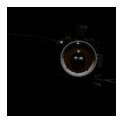

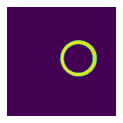

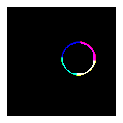

34


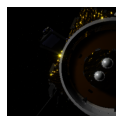

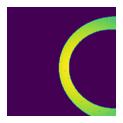

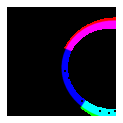

35


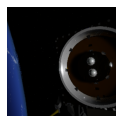

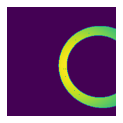

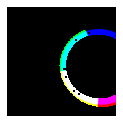

36


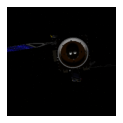

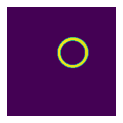

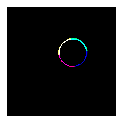

37


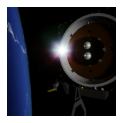

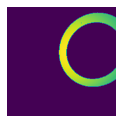

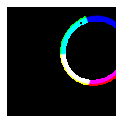

38


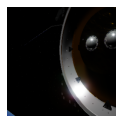

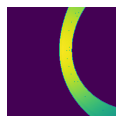

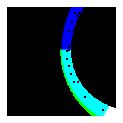

39


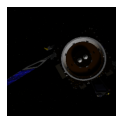

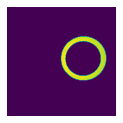

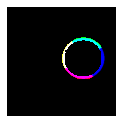

40


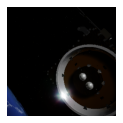

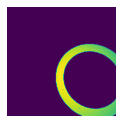

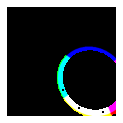

41


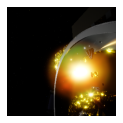

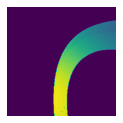

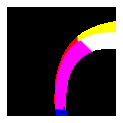

42


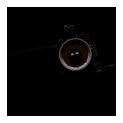

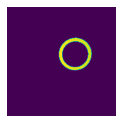

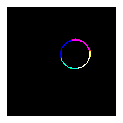

43


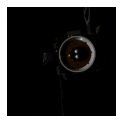

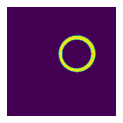

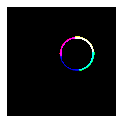

44


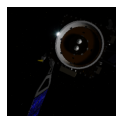

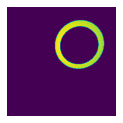

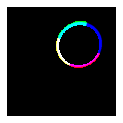

45


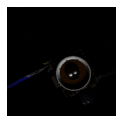

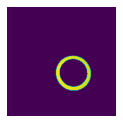

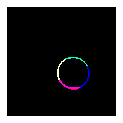

46


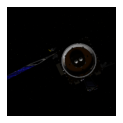

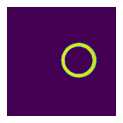

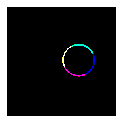

47


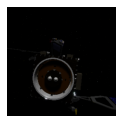

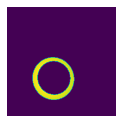

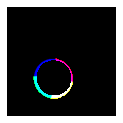

48


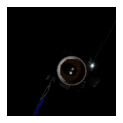

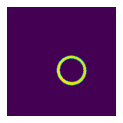

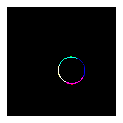

49


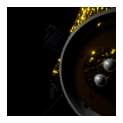

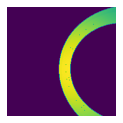

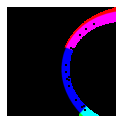

50


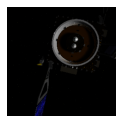

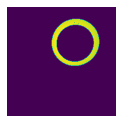

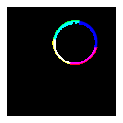

51


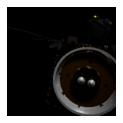

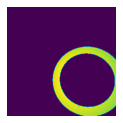

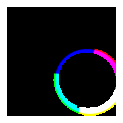

52


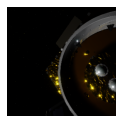

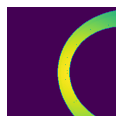

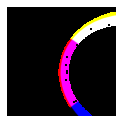

53


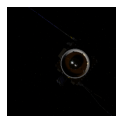

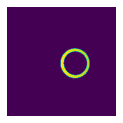

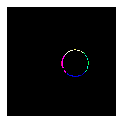

54


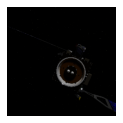

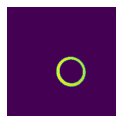

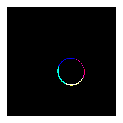

55


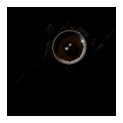

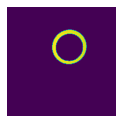

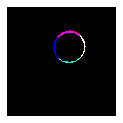

56


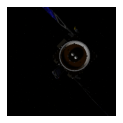

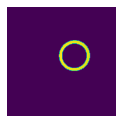

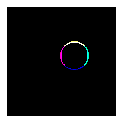

57


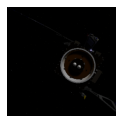

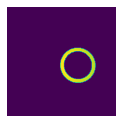

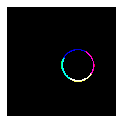

58


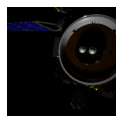

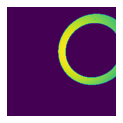

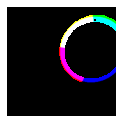

59


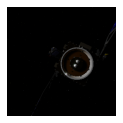

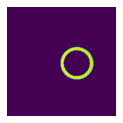

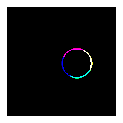

60


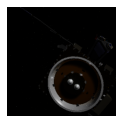

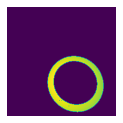

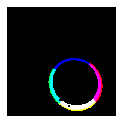

61


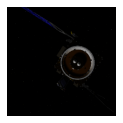

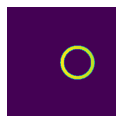

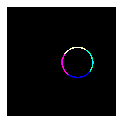

62


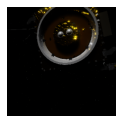

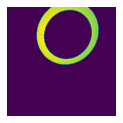

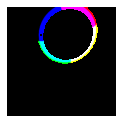

63


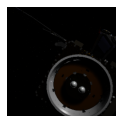

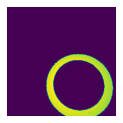

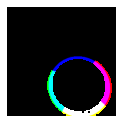

64


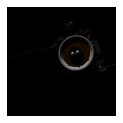

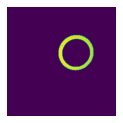

Exception ignored in: <function OffscreenRenderer.__del__ at 0x7f06eb3f8560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pyrender/offscreen.py", line 155, in __del__
    self.delete()
  File "/usr/local/lib/python3.7/dist-packages/pyrender/offscreen.py", line 127, in delete
    gc.collect()
KeyboardInterrupt: 


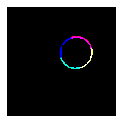

65


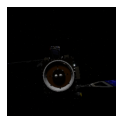

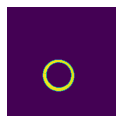

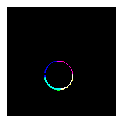

66


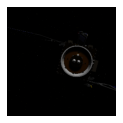

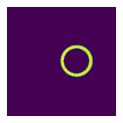

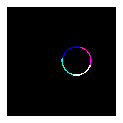

67


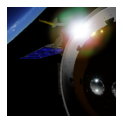

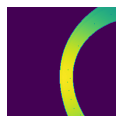

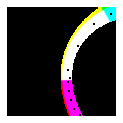

68


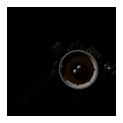

KeyboardInterrupt: ignored

In [ ]:
camK = np.array([[886.81/4,0.0,512.0/4],[0.0,886.81/4,512.0/4],[0.0,0.0,1.0]])
f = camK[0][0]
cx = camK[0][2]
cy = camK[1][2]

dtype = torch.float32
print(torch.cuda.is_available())

if par.USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

from scipy.spatial.transform import Rotation as R
for t, (x, y) in enumerate(tqdm(pose_dataset, leave=False)):
    print(t)
    x = np.transpose(x, (1,2,0))
    figure = plt.figure(figsize = (2, 2))
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    figure.savefig('x'+str(t)+'.png', bbox_inches='tight', pad_inches = 0)
    
    dep, Twc = print_pose(model_path=par.tm_path, pose=y, t=t)

    x_y_z = depth_to_point_cloud(dep, cx, cy, f)

    x_y_z = transform_points(x_y_z, Twc)

    figure = plt.figure(figsize = (2, 2))
    plt.imshow(x_y_z)
    plt.axis('off')
    plt.show()

    figure.savefig('x_y_z'+str(t)+'.png', bbox_inches='tight', pad_inches = 0)


    '''with open('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/3D points good 2/tensor' + str(t) + '.npy', 'wb') as fi:
        np.save(fi, x_y_z)'''
  

In [8]:
class PoseDataset(Dataset):

    def __init__(self, points_pt, root_dir):

        self.points_dir = points_pt
        #self.poses = poses.sort_values(by=["id"])
        self.root_dir = root_dir

    def __len__(self):
        return len([f for f in os.listdir(self.points_dir)if os.path.isfile(os.path.join(self.points_dir, f))])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                str(idx) + '-N_.png')
        
        img = imageio.imread(img_path, ignoregamma = True)
        rgb_img = img[:,:,:3]
        #print('rgb_img', rgb_img.shape)
        '''figure = plt.figure(figsize = (10, 10))
        plt.imshow(rgb_img)
        plt.show() 
'''
        img_tensor = torch.tensor(rgb_img)/255.0
        img_tensor = np.transpose(img_tensor, (2, 0, 1))
        #print('img_tensor', img_tensor.shape)
        img_downsampled = F.interpolate(img_tensor, scale_factor = 0.25)
        #print('img_downsampled', img_downsampled.shape)
        img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
        #print('img_downsampled', img_downsampled.shape)
        img_downsampled = F.interpolate(img_downsampled, scale_factor = 0.25)
        #print('img_downsampled', img_downsampled.shape)
        ###img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
        img_downsampled = np.transpose(img_downsampled, (2, 1, 0))
        #print('img_downsampled', img_downsampled.shape)
        img_downsampled = np.transpose(img_downsampled, (2, 0, 1))
        #print('img_downsampled', img_downsampled.shape)
        threeD_points = np.load(os.path.join('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/3D points good 2', 'tensor' + str(idx) + '.npy')) 
        threeD_points = np.transpose(threeD_points, (2, 0, 1))
        threeD_points = np.nan_to_num(threeD_points)

        '''figure = plt.figure(figsize = (10, 10))
        plt.imshow(img_downsampled)#, cmap = plt.cm.gray)
        plt.show()''' 
        '''figure = plt.figure(figsize = (10, 10))
        plt.imshow(threeD_points)#, cmap = plt.cm.gray)
        plt.show() '''

        return img_downsampled, threeD_points




In [9]:
points_dataset = PoseDataset(points_pt = 'drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/3D points good 2',
                           root_dir = par.root_path_2)
print(len(points_dataset))

19991


In [10]:
# Create train val test split
n = len(points_dataset)
print(n)
n_1 = int(n/8)

train_set, val_set, test_set = torch.utils.data.random_split(
    points_dataset, [n-(2*n_1), n_1, n_1])

print(len(train_set), len(val_set), len(test_set))

loader_train = DataLoader(train_set, batch_size=par.batch_size_1, shuffle=par.shuffle, num_workers=2)
loader_val = DataLoader(val_set, batch_size=par.batch_size_1, shuffle=par.shuffle, num_workers=2)
loader_test = DataLoader(test_set, batch_size=par.batch_size_1, shuffle=False, num_workers=2)

19991
14995 2498 2498


In [11]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        

    def forward(self, x):
        enc1 = self.encoder1(x)
        #print('enc1', enc1.shape)
        enc2 = self.encoder2(self.pool1(enc1))
        #print('enc2', enc2.shape)
        enc3 = self.encoder3(self.pool2(enc2))
        #print('enc3', enc3.shape)
        enc4 = self.encoder4(self.pool3(enc3))
        #print('enc4', enc4.shape)

        bottleneck = self.bottleneck(self.pool4(enc4))
        #print('bottleneck', bottleneck.shape)

        dec4 = self.upconv4(bottleneck)
        #print('dec4', dec4.shape)
        dec4 = torch.cat((dec4, enc4), dim=1)
        #print('dec4', dec4.shape)
        dec4 = self.decoder4(dec4)
        #print('dec4', dec4.shape)
        dec3 = self.upconv3(dec4)
        #print('dec3', dec3.shape)
        dec3 = torch.cat((dec3, enc3), dim=1)
        #print('dec3', dec3.shape)
        dec3 = self.decoder3(dec3)
        #print('dec3', dec3.shape)
        dec2 = self.upconv2(dec3)
        #print('dec2', dec2.shape)
        dec2 = torch.cat((dec2, enc2), dim=1)
        #print('dec2', dec2.shape)
        dec2 = self.decoder2(dec2)
        #print('dec2', dec2.shape)
        dec1 = self.upconv1(dec2)
        #print('dec1', dec1.shape)
        dec1 = torch.cat((dec1, enc1), dim=1)
        #print('dec1', dec1.shape)
        dec1 = self.decoder1(dec1)
        #print('dec1', dec1.shape)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [17]:
dtype = torch.float32

if par.USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

print_every = par.print_every

def train(model, optimizer, epochs, start_e):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """

    iter_val = iter(loader_val)
    losses = []
    val_losses = []

    tra_losses = []
    tra_val_losses = []

    rot_losses = []
    rot_val_losses = []

    print(len(loader_train))
    for e in tqdm(range(start_e, epochs)):
        if e == 0:
            learning_rate = par.learnig_rate
        else:
            learning_rate = learning_rate * 1/(1 + par.decay * e)
        for t, (x, y) in enumerate(tqdm(loader_train, leave=False)):
            ###print('y1', y.shape)
            ###print('x1', x.shape)

            optimizer = optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=par.weight_decay)
            #print('learning_rate', learning_rate)
            #print("x shape", x.shape)
            try:
                x_val, y_val = next(iter_val)
            except StopIteration:
                iter_val = iter(loader_val)
                x_val, y_val = next(iter_val)

            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #print('x', x)
            y = y.to(device=device, dtype=torch.float32)


            x_val = x_val.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y_val = y_val.to(device=device, dtype=dtype)

            scores = model(x)

            


        

            loss = F.mse_loss(scores, y)
            #loss_tra = F.mse_loss(scores_tra, y_tra)
            #loss_rot = F.mse_loss(scores_rot, y_rot)
            #print('loss', loss)
            losses.append(loss.item())
            #tra_losses.append(loss_tra.item())
            #rot_losses.append(loss_rot.item())


            #
            optimizer.zero_grad()

            loss.backward()

            with torch.no_grad():
                scores_val = model(x_val)
                val_loss = F.mse_loss(scores_val, y_val)
                val_losses.append(val_loss.item())

            wandb.log({
                "loss": loss,
                "val_loss": val_loss,
                #"tra_loss [cm]": loss_tra,
                #"tra_val_loss [cm]": val_loss_tra,
                #"rot_loss [°]": loss_rot,
                #"rot_val_loss [°]": val_loss_rot,
                "learning_rate": learning_rate
                })
        

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                

        torch.save({ # Save our checkpoint loc
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"{par.checkpoint_path}/{run.id}.tar")
        wandb.save(f"{par.checkpoint_path}/{run.id}.tar") # saves checkpoint to wandb

    plt.figure(figsize=(10,7))
    plt.title("Learning curve traslations")
    plt.plot(tra_losses, label="Training loss")
    plt.plot(tra_val_losses, label="Validation loss")
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend()
    plt.savefig('learning_curve.png', bbox_inches='tight', dpi=150)
    plt.show()

    plt.figure(figsize=(10,7))
    plt.title("Learning curve rotations")
    plt.plot(rot_losses, label="Training loss")
    plt.plot(rot_val_losses, label="Validation loss")
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend()
    plt.savefig('learning_curve.png', bbox_inches='tight', dpi=150)
    plt.show()


cuda:0


In [12]:
print(par.run_id)
if par.resume:
    run = wandb.init(project="Deep Pose Estimation PnP Downsampled", 
                        entity="cuccomat",
                        id=par.run_id,
                        resume=True)
else:
    run = wandb.init(project="Deep Pose Estimation PnP Downsampled", 
            entity="cuccomat",
            config = {
                    "learning_rate": par.learning_rate,
                    "lr_decay": par.decay,
                    "weight_decay": par.weight_decay,
                    "batch_size": par.batch_size_1,
                    "epochs": par.epochs
                })

3ksiu9sw


wandb: Currently logged in as: cuccomat. Use `wandb login --relogin` to force relogin


In [13]:
print(torch.cuda.is_available())
if par.USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)


torch.autograd.set_detect_anomaly(True)
model = UNet()
model = model.to(device=device)  # move the model parameters to CPU/GPU
optimizer = optim.Adamax(model.parameters(), lr=par.learning_rate, weight_decay=par.weight_decay)
epoch = 0
if wandb.run.resumed:
    wandb.restore(f"{par.checkpoint_path}/{par.run_id}.tar")
    checkpoint = torch.load(f"{par.checkpoint_path}/{par.run_id}.tar", map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(epoch)

True
cuda:0
78


In [ ]:
# define and train the network
'''params_sum = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params_sum))'''

train(model, optimizer, epochs=par.epochs, start_e=epoch)

losses = []
val_losses = []

# save the model
torch.save(model.state_dict(), 'model.pt')

250


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 72, Iteration 0, loss = 0.9484
Epoch: 72, Iteration 10, loss = 1.2236
Epoch: 72, Iteration 20, loss = 0.9170
Epoch: 72, Iteration 30, loss = 1.1427
Epoch: 72, Iteration 40, loss = 1.2677
Epoch: 72, Iteration 50, loss = 1.1005
Epoch: 72, Iteration 60, loss = 1.3203
Epoch: 72, Iteration 70, loss = 1.7640
Epoch: 72, Iteration 80, loss = 1.2929
Epoch: 72, Iteration 90, loss = 1.0824
Epoch: 72, Iteration 100, loss = 1.1606
Epoch: 72, Iteration 110, loss = 1.0153
Epoch: 72, Iteration 120, loss = 1.0717
Epoch: 72, Iteration 130, loss = 1.0220
Epoch: 72, Iteration 140, loss = 1.2173
Epoch: 72, Iteration 150, loss = 1.2071
Epoch: 72, Iteration 160, loss = 1.0433
Epoch: 72, Iteration 170, loss = 1.2308
Epoch: 72, Iteration 180, loss = 1.1990
Epoch: 72, Iteration 190, loss = 1.1585
Epoch: 72, Iteration 200, loss = 0.9684
Epoch: 72, Iteration 210, loss = 1.0629
Epoch: 72, Iteration 220, loss = 1.0292
Epoch: 72, Iteration 230, loss = 1.1602
Epoch: 72, Iteration 240, loss = 0.9848


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 73, Iteration 0, loss = 1.0577
Epoch: 73, Iteration 10, loss = 0.8647
Epoch: 73, Iteration 20, loss = 0.8656
Epoch: 73, Iteration 30, loss = 0.9960
Epoch: 73, Iteration 40, loss = 1.1220
Epoch: 73, Iteration 50, loss = 1.1085
Epoch: 73, Iteration 60, loss = 1.1833
Epoch: 73, Iteration 70, loss = 1.0796
Epoch: 73, Iteration 80, loss = 0.9043
Epoch: 73, Iteration 90, loss = 1.0361
Epoch: 73, Iteration 100, loss = 1.0533
Epoch: 73, Iteration 110, loss = 1.0732
Epoch: 73, Iteration 120, loss = 1.1373
Epoch: 73, Iteration 130, loss = 1.2262
Epoch: 73, Iteration 140, loss = 1.0138
Epoch: 73, Iteration 150, loss = 1.1676
Epoch: 73, Iteration 160, loss = 0.9825
Epoch: 73, Iteration 170, loss = 0.9776
Epoch: 73, Iteration 180, loss = 1.0575
Epoch: 73, Iteration 190, loss = 1.1081
Epoch: 73, Iteration 200, loss = 1.1532
Epoch: 73, Iteration 210, loss = 1.0359
Epoch: 73, Iteration 220, loss = 0.8269
Epoch: 73, Iteration 230, loss = 1.0638
Epoch: 73, Iteration 240, loss = 1.4320


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 74, Iteration 0, loss = 1.0374
Epoch: 74, Iteration 10, loss = 1.2529
Epoch: 74, Iteration 20, loss = 1.0278
Epoch: 74, Iteration 30, loss = 0.9123
Epoch: 74, Iteration 40, loss = 0.9609
Epoch: 74, Iteration 50, loss = 0.9610
Epoch: 74, Iteration 60, loss = 0.9416
Epoch: 74, Iteration 70, loss = 0.8580
Epoch: 74, Iteration 80, loss = 1.0174
Epoch: 74, Iteration 90, loss = 1.1091
Epoch: 74, Iteration 100, loss = 1.0987
Epoch: 74, Iteration 110, loss = 1.3001
Epoch: 74, Iteration 120, loss = 1.2807
Epoch: 74, Iteration 130, loss = 1.1029
Epoch: 74, Iteration 140, loss = 1.1768
Epoch: 74, Iteration 150, loss = 1.0019
Epoch: 74, Iteration 160, loss = 0.9748
Epoch: 74, Iteration 170, loss = 0.9004
Epoch: 74, Iteration 180, loss = 0.9368
Epoch: 74, Iteration 190, loss = 1.0094
Epoch: 74, Iteration 200, loss = 1.4588
Epoch: 74, Iteration 210, loss = 1.1469
Epoch: 74, Iteration 220, loss = 1.2959
Epoch: 74, Iteration 230, loss = 1.3198
Epoch: 74, Iteration 240, loss = 1.0560


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 75, Iteration 0, loss = 0.9703
Epoch: 75, Iteration 10, loss = 0.8941
Epoch: 75, Iteration 20, loss = 0.9031
Epoch: 75, Iteration 30, loss = 1.0829
Epoch: 75, Iteration 40, loss = 1.0480
Epoch: 75, Iteration 50, loss = 1.0622
Epoch: 75, Iteration 60, loss = 0.9860
Epoch: 75, Iteration 70, loss = 1.0087
Epoch: 75, Iteration 80, loss = 0.9202
Epoch: 75, Iteration 90, loss = 0.8452
Epoch: 75, Iteration 100, loss = 1.1261
Epoch: 75, Iteration 110, loss = 1.1605
Epoch: 75, Iteration 120, loss = 1.1982
Epoch: 75, Iteration 130, loss = 0.8932
Epoch: 75, Iteration 140, loss = 1.0375
Epoch: 75, Iteration 150, loss = 0.9437
Epoch: 75, Iteration 160, loss = 1.2881
Epoch: 75, Iteration 170, loss = 0.8028
Epoch: 75, Iteration 180, loss = 1.0869
Epoch: 75, Iteration 190, loss = 0.9843
Epoch: 75, Iteration 200, loss = 0.9674
Epoch: 75, Iteration 210, loss = 1.1783
Epoch: 75, Iteration 220, loss = 0.9518
Epoch: 75, Iteration 230, loss = 0.9245
Epoch: 75, Iteration 240, loss = 0.9246


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 76, Iteration 0, loss = 0.9992
Epoch: 76, Iteration 10, loss = 0.9560
Epoch: 76, Iteration 20, loss = 1.1142
Epoch: 76, Iteration 30, loss = 1.2460
Epoch: 76, Iteration 40, loss = 0.8777
Epoch: 76, Iteration 50, loss = 0.8524
Epoch: 76, Iteration 60, loss = 0.8032
Epoch: 76, Iteration 70, loss = 1.0224
Epoch: 76, Iteration 80, loss = 0.9502
Epoch: 76, Iteration 90, loss = 1.0177
Epoch: 76, Iteration 100, loss = 0.8923
Epoch: 76, Iteration 110, loss = 0.8991
Epoch: 76, Iteration 120, loss = 1.1781
Epoch: 76, Iteration 130, loss = 0.8182
Epoch: 76, Iteration 140, loss = 0.8267
Epoch: 76, Iteration 150, loss = 1.1237
Epoch: 76, Iteration 160, loss = 0.9319
Epoch: 76, Iteration 170, loss = 0.8467
Epoch: 76, Iteration 180, loss = 0.9407
Epoch: 76, Iteration 190, loss = 0.9474
Epoch: 76, Iteration 200, loss = 0.8674
Epoch: 76, Iteration 210, loss = 0.9456
Epoch: 76, Iteration 220, loss = 0.8672
Epoch: 76, Iteration 230, loss = 0.9133
Epoch: 76, Iteration 240, loss = 0.9051


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 77, Iteration 0, loss = 0.8751
Epoch: 77, Iteration 10, loss = 0.8774
Epoch: 77, Iteration 20, loss = 0.9417
Epoch: 77, Iteration 30, loss = 0.8687
Epoch: 77, Iteration 40, loss = 0.9994
Epoch: 77, Iteration 50, loss = 0.8790
Epoch: 77, Iteration 60, loss = 1.2864
Epoch: 77, Iteration 70, loss = 1.1589
Epoch: 77, Iteration 80, loss = 0.9860
Epoch: 77, Iteration 90, loss = 1.0393
Epoch: 77, Iteration 100, loss = 1.0634
Epoch: 77, Iteration 110, loss = 0.8814
Epoch: 77, Iteration 120, loss = 0.8636
Epoch: 77, Iteration 130, loss = 0.8560
Epoch: 77, Iteration 140, loss = 0.8725
Epoch: 77, Iteration 150, loss = 0.9591
Epoch: 77, Iteration 160, loss = 0.9646
Epoch: 77, Iteration 170, loss = 0.8609
Epoch: 77, Iteration 180, loss = 1.1483
Epoch: 77, Iteration 190, loss = 0.9889
Epoch: 77, Iteration 200, loss = 0.8190
Epoch: 77, Iteration 210, loss = 0.7641
Epoch: 77, Iteration 220, loss = 0.8777
Epoch: 77, Iteration 230, loss = 1.0933
Epoch: 77, Iteration 240, loss = 0.8980


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 78, Iteration 0, loss = 1.0326
Epoch: 78, Iteration 10, loss = 0.9247
Epoch: 78, Iteration 20, loss = 0.8204
Epoch: 78, Iteration 30, loss = 0.9690
Epoch: 78, Iteration 40, loss = 0.9152
Epoch: 78, Iteration 50, loss = 0.9873
Epoch: 78, Iteration 60, loss = 0.8077
Epoch: 78, Iteration 70, loss = 0.8447
Epoch: 78, Iteration 80, loss = 0.8329
Epoch: 78, Iteration 90, loss = 0.8853
Epoch: 78, Iteration 100, loss = 0.9421
Epoch: 78, Iteration 110, loss = 0.8215
Epoch: 78, Iteration 120, loss = 0.8979
Epoch: 78, Iteration 130, loss = 0.7675
Epoch: 78, Iteration 140, loss = 1.1634
Epoch: 78, Iteration 150, loss = 0.8633
Epoch: 78, Iteration 160, loss = 0.9019
Epoch: 78, Iteration 170, loss = 0.8062
Epoch: 78, Iteration 180, loss = 0.8288
Epoch: 78, Iteration 190, loss = 0.8984
Epoch: 78, Iteration 200, loss = 1.3794


In [16]:
from scipy.spatial import distance
from scipy.spatial.transform import Rotation as R
!pip install opencv-python
import cv2
camK = np.array([[886.81/4,0.0,512.0/4],[0.0,886.81/4,512.0/4],[0.0,0.0,1.0]])
distortion_coeffs = np.zeros((4,1)) #TO CHECK
# TEST
#Is it possibile to set an initial value for traslations and rotations?
def test_part(model):
    iter_test = iter(loader_test)
    with torch.no_grad():
        for t, (x, y) in enumerate(tqdm(loader_test, leave=False)):
            torch.set_printoptions(profile="default")
            
            try:
                x_test, y_test = next(iter_test)
            except StopIteration:
                iter_test = iter(loader_test)
                x_test, y_test = next(iter_test)

            x_test = x_test.to(device=device, dtype=dtype)
            y_test = y_test.to(device=device, dtype=dtype)
            predictions = model(x_test)

            y_test = y_test.cpu()
            x_test = x_test.cpu()
            predictions = predictions.cpu()

            print('#################GT')
            figure = plt.figure(figsize = (5, 5))
            plt.imshow(np.transpose(x_test[t], (1, 2, 0)))
            plt.axis('off')
            plt.show()
            #figure.savefig('x_y_z_gt'+str(t)+'.png', bbox_inches='tight', pad_inches = 0)

            print('#################GT')
            figure = plt.figure(figsize = (5, 5))
            plt.imshow(np.transpose(y_test[t], (1, 2, 0)))
            plt.axis('off')
            plt.show()
            #figure.savefig('x_y_z_gt'+str(t)+'.png', bbox_inches='tight', pad_inches = 0)

    

            print('#####################PRED')
            figure = plt.figure(figsize = (5, 5))
            plt.imshow(np.transpose(predictions[t], (1,2,0)))
            plt.axis('off')
            plt.show()

            #figure.savefig('x_y_z_pred'+str(t)+'.png', bbox_inches='tight', pad_inches = 0)
            
        

                 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


cuda


  0%|          | 0/42 [00:00<?, ?it/s]

#################GT


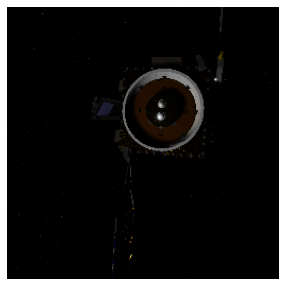

#################GT


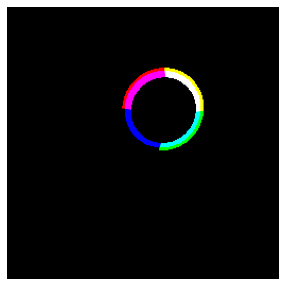

#####################PRED


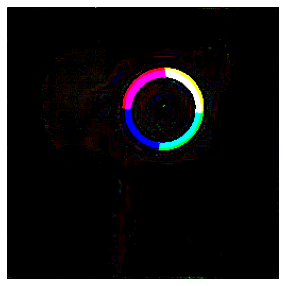

#################GT


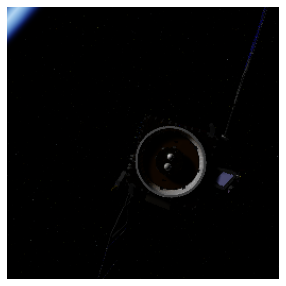

#################GT


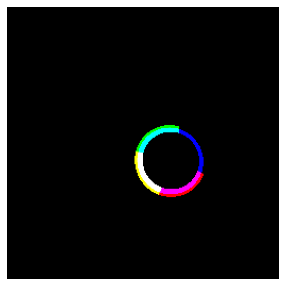

#####################PRED


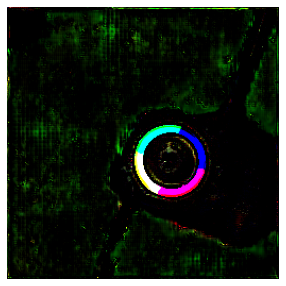

#################GT


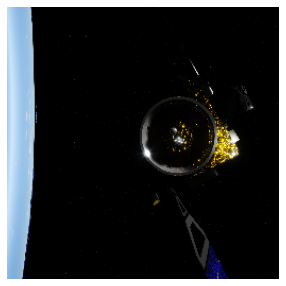

#################GT


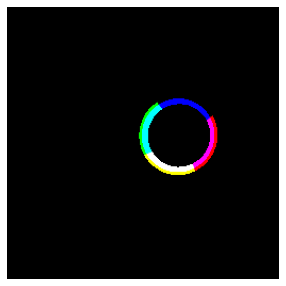

#####################PRED


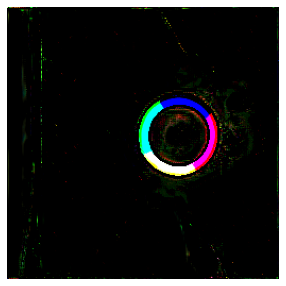

#################GT


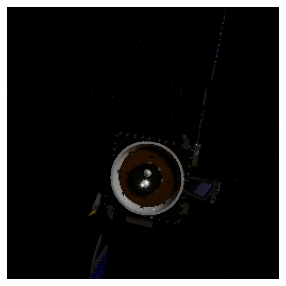

#################GT


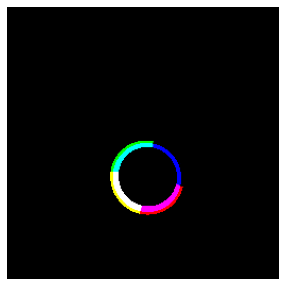

#####################PRED


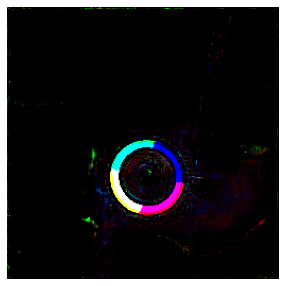

#################GT


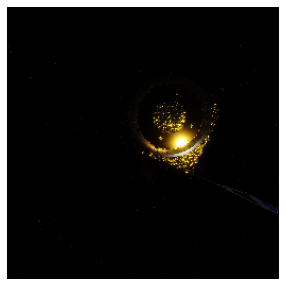

#################GT


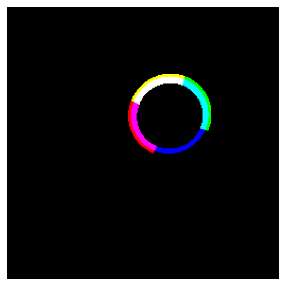

#####################PRED


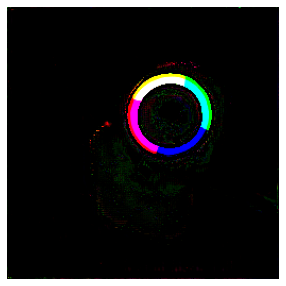

#################GT


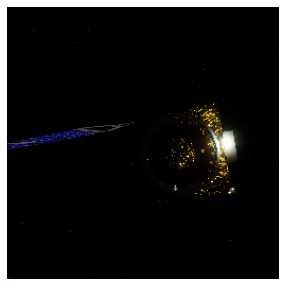

#################GT


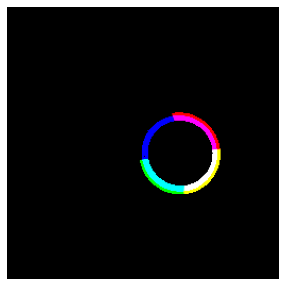

#####################PRED


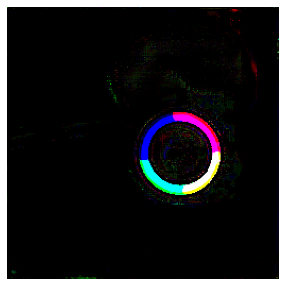

#################GT


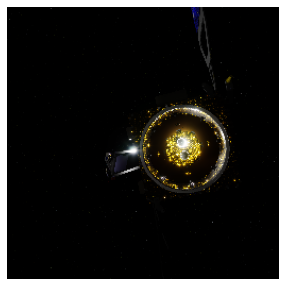

#################GT


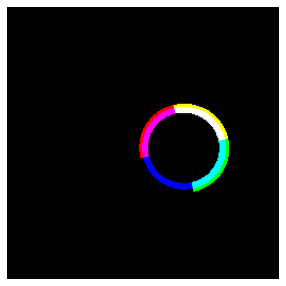

#####################PRED


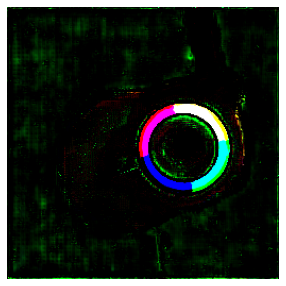

#################GT


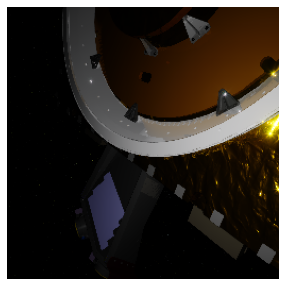

#################GT


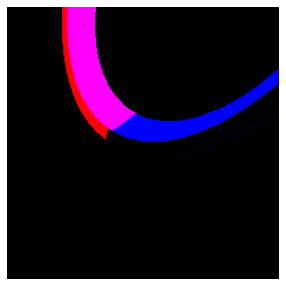

#####################PRED


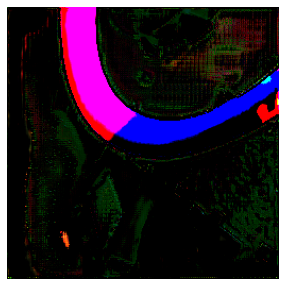

#################GT


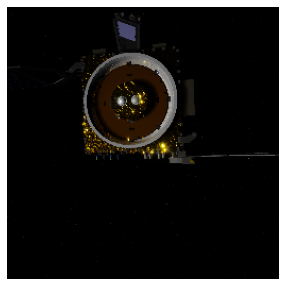

#################GT


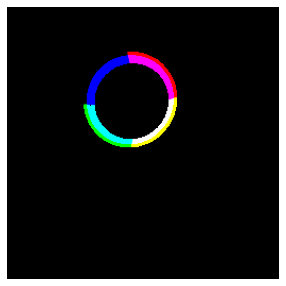

#####################PRED


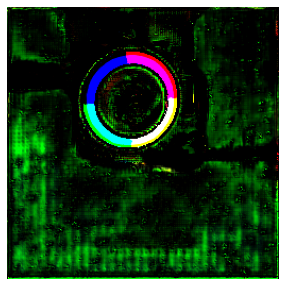

#################GT


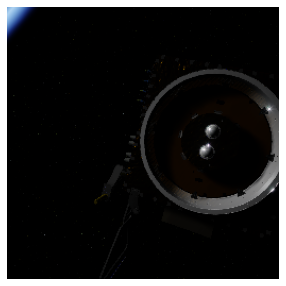

#################GT


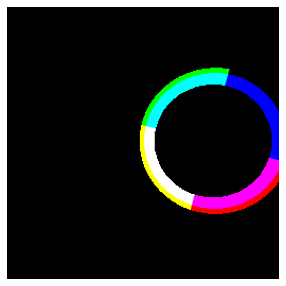

#####################PRED


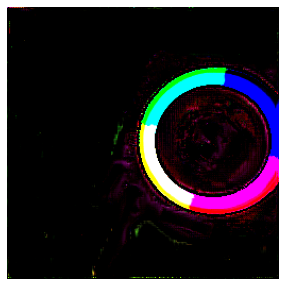

#################GT


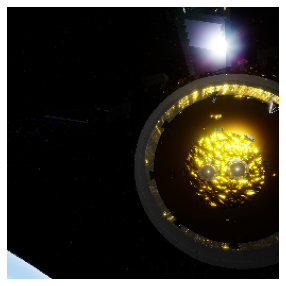

#################GT


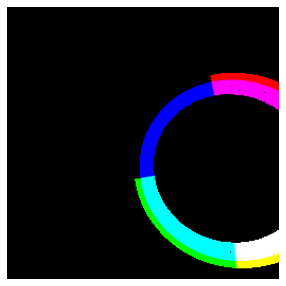

#####################PRED


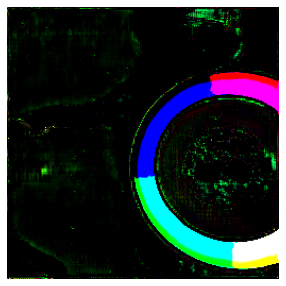

#################GT


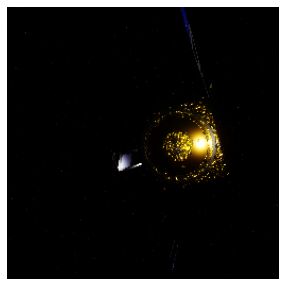

#################GT


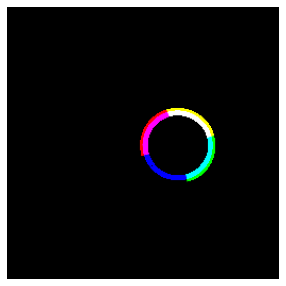

#####################PRED


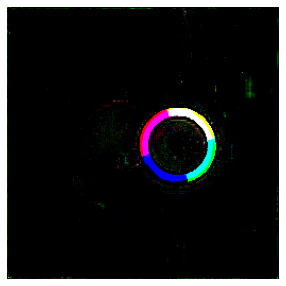

In [ ]:
torch.set_printoptions(profile="full")
dtype = torch.float32


device = torch.device('cuda')
print(device)

model = UNet()
model = model.to(device=device)
checkpoint = torch.load(f"{par.checkpoint_path}/{par.run_id}.tar")
model.load_state_dict(checkpoint['model_state_dict'])

test_part(model)